# MULTIVARIATE STOCK VALUE PREDICTION USING LONG-SHORT-TERM-MEMORY (LSTM)

##### NASDAQ data source: "https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC"

### IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

### LOAD NASDAQ DATA

In [2]:
nasdaq = pd.read_csv('nasdaq5Y.csv')
nasdaq.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1253,2023-06-07,13295.259766,13361.900391,13089.480469,13104.900391,13104.900391,5270600000
1254,2023-06-08,13113.269531,13248.599609,13101.179688,13238.519531,13238.519531,4280160000
1255,2023-06-09,13312.389648,13385.950195,13229.330078,13259.139648,13259.139648,4412710000
1256,2023-06-12,13326.370117,13465.910156,13302.580078,13461.919922,13461.919922,4722680000
1257,2023-06-13,13566.530273,13594.400391,13473.190430,13573.320313,13573.320313,5522100000


### DATA CLEANING

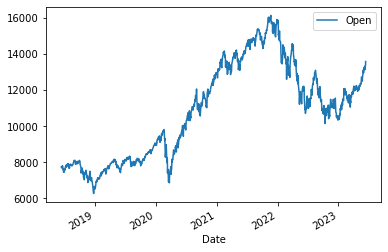

In [3]:
nasdaq['Date'] = pd.to_datetime(nasdaq['Date'])
nasdaq.plot.line(y="Open", x='Date');

In [4]:
nasdaq.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [5]:
# nasdaq['Target'] = nasdaq['Open'].shift(-1)
# nasdaq.head()

In [6]:
predictors = list(nasdaq)[1:6]
predictors

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [7]:
data = nasdaq[predictors].astype('float')
# data['Target'] = data['Open'].shift(-14)
data.head()

,Open,High,Low,Close,Adj Close
0,7723.529785,7768.600098,7723.529785,7761.040039,7761.040039
1,7725.029785,7755.720215,7704.339844,7746.379883,7746.379883
2,7692.959961,7749.359863,7676.830078,7747.029785,7747.029785
3,7658.470215,7727.410156,7635.729980,7725.589844,7725.589844
4,7764.149902,7806.600098,7755.479980,7781.509766,7781.509766


In [8]:
train_dates = nasdaq['Date']


### SCALING THE DATA

In [9]:
scaler = StandardScaler()
scaler = scaler.fit(data)
data_scaled = scaler.transform(data)

data_scaled

array([[-1.18217812, -1.18949504, -1.15733411, -1.16936247, -1.16936247],
       [-1.18161088, -1.19433607, -1.16465427, -1.17491047, -1.17491047],
       [-1.19373851, -1.19672667, -1.17514809, -1.17466452, -1.17466452],
       ...,
       [ 0.93132445,  0.92183972,  0.94289857,  0.91134128,  0.91134128],
       [ 0.93661135,  0.95189344,  0.97084039,  0.98808156,  0.98808156],
       [ 1.02743114,  1.00018772,  1.0359211 ,  1.03023998,  1.03023998]])

### Train - Test split

In [10]:
trainX = []
trainY = []

testX = []
testY = []

# Train on last two weeks data and validate on the next day's Open price
n_future = 1
n_past = 14
test_length = 60

for i in range(n_past, len(data_scaled)-test_length):
    trainX.append(data_scaled[i-n_past:i, :6])
    trainY.append(data_scaled[i + n_future - 1:i + n_future, 0])

for j in range(len(data_scaled)-test_length, len(data_scaled)):
    testX.append(data_scaled[j-n_past:j, :6])
    testY.append(data_scaled[j:j+1, 0])

trainX = np.array(trainX)
trainY = np.array(trainY)

testX = np.array(testX)
testY = np.array(testY)

trainX.shape, trainY.shape, testX.shape, testY.shape

((1184, 14, 5), (1184, 1), (60, 14, 5), (60, 1))

### AUTOENCODER MODEL

In [11]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


#### FIT MODEL

In [12]:
cp = ModelCheckpoint('model/', save_best_only=True)

In [13]:
history = model.fit(trainX, trainY, epochs=50, batch_size=16, validation_split=0.1, verbose=1, callbacks=[cp])

Epoch 1/50
63/67 [===========================>..] - ETA: 0s - loss: 0.2823

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 13s 146ms/step - loss: 0.2729 - val_loss: 0.0145
Epoch 2/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0630 - val_loss: 0.0155
Epoch 3/50
63/67 [===========================>..] - ETA: 0s - loss: 0.0540

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 135ms/step - loss: 0.0532 - val_loss: 0.0127
Epoch 4/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0476 - val_loss: 0.0137
Epoch 5/50
63/67 [===========================>..] - ETA: 0s - loss: 0.0465

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 134ms/step - loss: 0.0466 - val_loss: 0.0100
Epoch 6/50
63/67 [===========================>..] - ETA: 0s - loss: 0.0456

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 131ms/step - loss: 0.0463 - val_loss: 0.0097
Epoch 7/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0420 - val_loss: 0.0100
Epoch 8/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0397 - val_loss: 0.0108
Epoch 9/50
67/67 [==============================] - ETA: 0s - loss: 0.0396

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 133ms/step - loss: 0.0396 - val_loss: 0.0091
Epoch 10/50
67/67 [==============================] - 1s 9ms/step - loss: 0.0402 - val_loss: 0.0093
Epoch 11/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0412 - val_loss: 0.0114
Epoch 12/50
64/67 [===========================>..] - ETA: 0s - loss: 0.0436

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 10s 153ms/step - loss: 0.0433 - val_loss: 0.0081
Epoch 13/50
67/67 [==============================] - ETA: 0s - loss: 0.0392

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 142ms/step - loss: 0.0392 - val_loss: 0.0080
Epoch 14/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0391 - val_loss: 0.0088
Epoch 15/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0412 - val_loss: 0.0101
Epoch 16/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0369 - val_loss: 0.0086
Epoch 17/50
67/67 [==============================] - ETA: 0s - loss: 0.0388

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 138ms/step - loss: 0.0388 - val_loss: 0.0079
Epoch 18/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0426 - val_loss: 0.0107
Epoch 19/50
66/67 [============================>.] - ETA: 0s - loss: 0.0412

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 142ms/step - loss: 0.0411 - val_loss: 0.0079
Epoch 20/50
64/67 [===========================>..] - ETA: 0s - loss: 0.0392

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 10s 147ms/step - loss: 0.0391 - val_loss: 0.0074
Epoch 21/50
63/67 [===========================>..] - ETA: 0s - loss: 0.0365

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 137ms/step - loss: 0.0362 - val_loss: 0.0070
Epoch 22/50
67/67 [==============================] - 1s 9ms/step - loss: 0.0398 - val_loss: 0.0077
Epoch 23/50
64/67 [===========================>..] - ETA: 0s - loss: 0.0416

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 136ms/step - loss: 0.0415 - val_loss: 0.0067
Epoch 24/50
67/67 [==============================] - 1s 9ms/step - loss: 0.0348 - val_loss: 0.0070
Epoch 25/50
67/67 [==============================] - 1s 9ms/step - loss: 0.0375 - val_loss: 0.0078
Epoch 26/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0346 - val_loss: 0.0076
Epoch 27/50
64/67 [===========================>..] - ETA: 0s - loss: 0.0364

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 141ms/step - loss: 0.0373 - val_loss: 0.0063
Epoch 28/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0343 - val_loss: 0.0069
Epoch 29/50
63/67 [===========================>..] - ETA: 0s - loss: 0.0393

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 141ms/step - loss: 0.0389 - val_loss: 0.0056
Epoch 30/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0350 - val_loss: 0.0058
Epoch 31/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0367 - val_loss: 0.0062
Epoch 32/50
63/67 [===========================>..] - ETA: 0s - loss: 0.0371

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 143ms/step - loss: 0.0366 - val_loss: 0.0054
Epoch 33/50
63/67 [===========================>..] - ETA: 0s - loss: 0.0375

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 135ms/step - loss: 0.0377 - val_loss: 0.0053
Epoch 34/50
66/67 [============================>.] - ETA: 0s - loss: 0.0346

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 139ms/step - loss: 0.0348 - val_loss: 0.0045
Epoch 35/50
67/67 [==============================] - 1s 10ms/step - loss: 0.0311 - val_loss: 0.0062
Epoch 36/50
67/67 [==============================] - 1s 9ms/step - loss: 0.0339 - val_loss: 0.0055
Epoch 37/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0344 - val_loss: 0.0046
Epoch 38/50
65/67 [============================>.] - ETA: 0s - loss: 0.0347

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 141ms/step - loss: 0.0346 - val_loss: 0.0042
Epoch 39/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0363 - val_loss: 0.0057
Epoch 40/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0389 - val_loss: 0.0086
Epoch 41/50
63/67 [===========================>..] - ETA: 0s - loss: 0.0413

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 135ms/step - loss: 0.0410 - val_loss: 0.0042
Epoch 42/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0330 - val_loss: 0.0042
Epoch 43/50
64/67 [===========================>..] - ETA: 0s - loss: 0.0354

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 143ms/step - loss: 0.0352 - val_loss: 0.0039
Epoch 44/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0325 - val_loss: 0.0053
Epoch 45/50
67/67 [==============================] - ETA: 0s - loss: 0.0330

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 142ms/step - loss: 0.0330 - val_loss: 0.0035
Epoch 46/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0341 - val_loss: 0.0038
Epoch 47/50
67/67 [==============================] - ETA: 0s - loss: 0.0345

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 143ms/step - loss: 0.0345 - val_loss: 0.0035
Epoch 48/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0311 - val_loss: 0.0036
Epoch 49/50
67/67 [==============================] - 1s 8ms/step - loss: 0.0329 - val_loss: 0.0049
Epoch 50/50
62/67 [==========================>...] - ETA: 0s - loss: 0.0337

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


67/67 [==============================] - 9s 134ms/step - loss: 0.0335 - val_loss: 0.0031


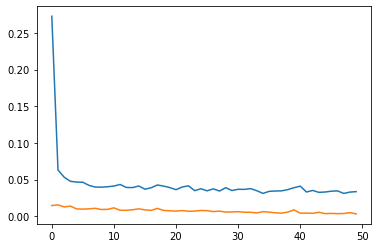

In [14]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.show()

#### MODEL FORECAST / PREDICTION

In [15]:
forecast = model.predict(testX)

2/2 [==============================] - 0s 5ms/step


In [16]:
forecast_copies = np.repeat(forecast, data.shape[1], axis=-1)

y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

y_pred_future

array([11589.228 , 11609.593 , 11718.758 , 11710.565 , 11735.488 ,
       11735.825 , 11737.535 , 11681.95  , 11787.94  , 11894.1   ,
       12025.134 , 12081.811 , 12080.715 , 11978.82  , 11970.64  ,
       11976.065 , 11976.316 , 11930.421 , 12017.879 , 12048.492 ,
       12066.058 , 12092.876 , 12079.489 , 12022.46  , 11999.987 ,
       11978.304 , 11835.053 , 11814.392 , 11963.374 , 12078.064 ,
       12132.09  , 12064.782 , 12014.09  , 11936.56  , 12067.049 ,
       12146.139 , 12131.77  , 12192.427 , 12234.682 , 12226.481 ,
       12261.272 , 12279.146 , 12355.244 , 12474.951 , 12542.373 ,
       12595.955 , 12550.24  , 12441.765 , 12545.482 , 12701.78  ,
       12829.412 , 12841.229 , 12911.143 , 13023.546 , 13083.1045,
       13119.958 , 13079.108 , 13100.647 , 13146.875 , 13249.3545],
      dtype=float32)

In [17]:
forecast_period_dates = list(train_dates)[-test_length:]
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

data_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Predicted Close':y_pred_future, 'Actual Open':data['Open'].tail(test_length)})

In [18]:
data_forecast.index = data_forecast['Date']
data_forecast.head()

,Date,Predicted Close,Actual Open
Date,,,
2023-03-20,2023-03-20,11589.227539,11614.389648
2023-03-21,2023-03-21,11609.592773,11764.790039
2023-03-22,2023-03-22,11718.757812,11857.500000
2023-03-23,2023-03-23,11710.565430,11811.320313
2023-03-24,2023-03-24,11735.488281,11747.620117


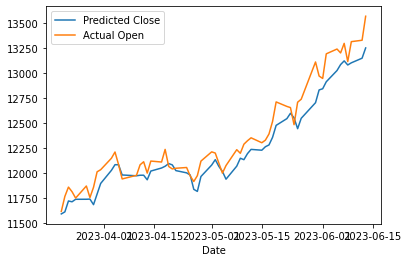

In [19]:
data_forecast.plot();

## OBSERVATION: 
###  - Even though the model is not near identical to the actual price,  from the plot above it is evident that it is quite effective in detecting the trend (rise / fall) of the stock value. 
###  - Converting the model to a classification task of "Will the price increase the next day?" should result in improved effectiveness. 
### - Additionally, training for more epochs in addition to training on more data (10 years data) could prove effctive.